In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

### Dataset :
Seoul Bike Sharing Demand. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5F62R.

Source : Data Source : http://data.seoul.go.kr/ SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.co.kr

In [2]:
dataset_cols = [
    'bike_count',
    'hour',
    'temp',
    'humidity',
    'wind',
    'visibility',
    'dew_pt_temp',
    'radiation',
    'rain',
    'snow',
    'functional'
]

In [6]:
df = pd.read_csv('SeoulBikeData.csv').drop(['Date','Holiday','Seasons'], axis=1)

In [13]:
df.columns = dataset_cols
df['functional'] = (df['functional']=='Yes').astype('int')
df = df[df['hour']==12]    # only display data from hour 12
df = df.drop(['hour'], axis = 1)

In [16]:
df.shape[0]

365

In [15]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,0
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,0
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,0
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,0
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,0


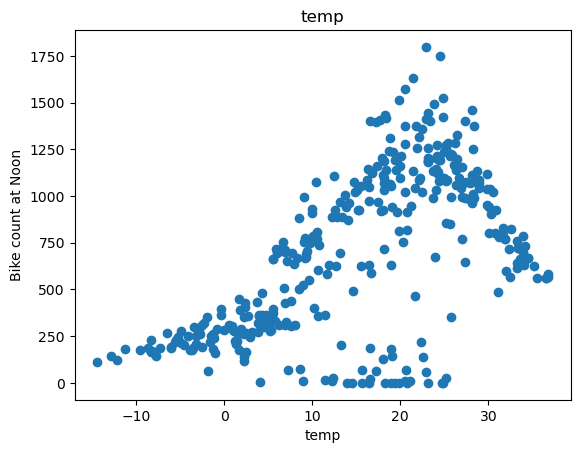

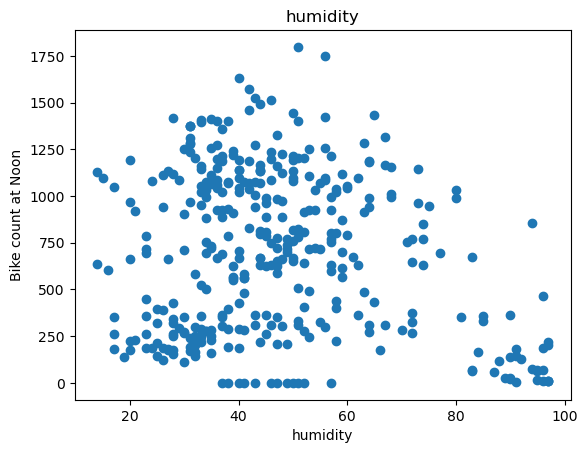

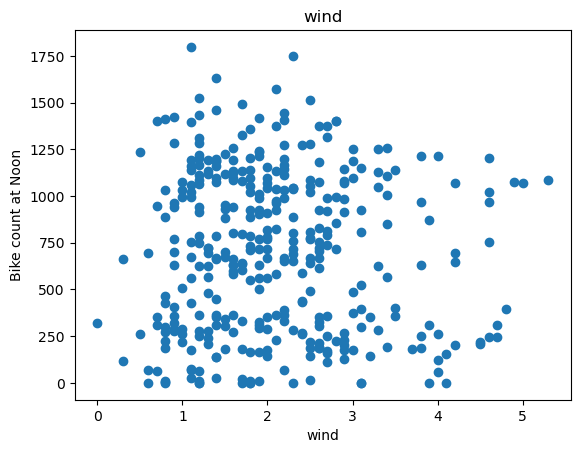

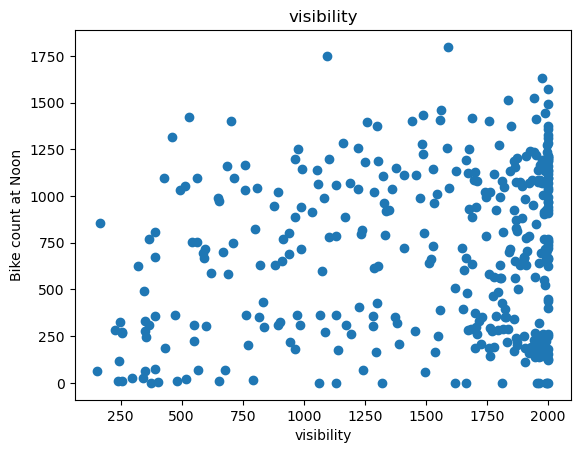

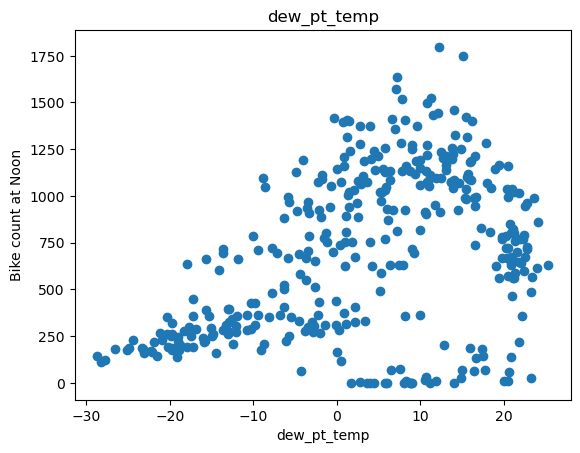

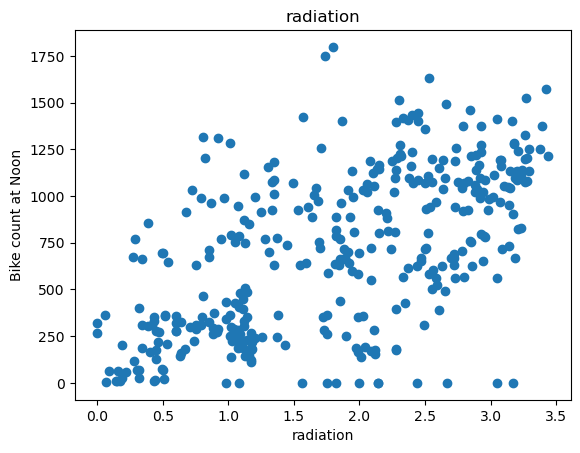

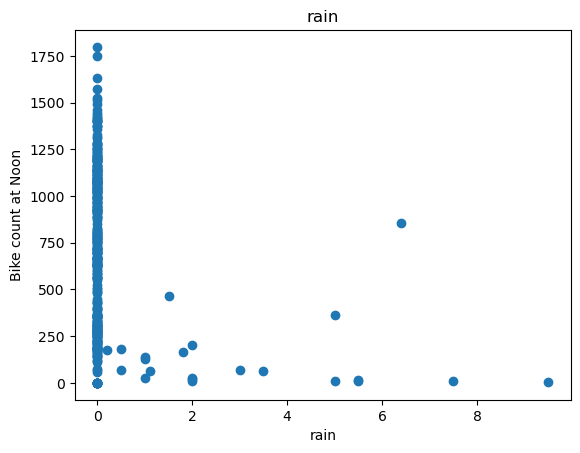

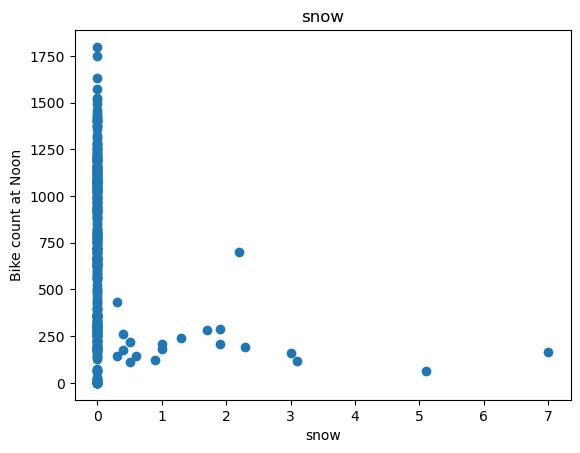

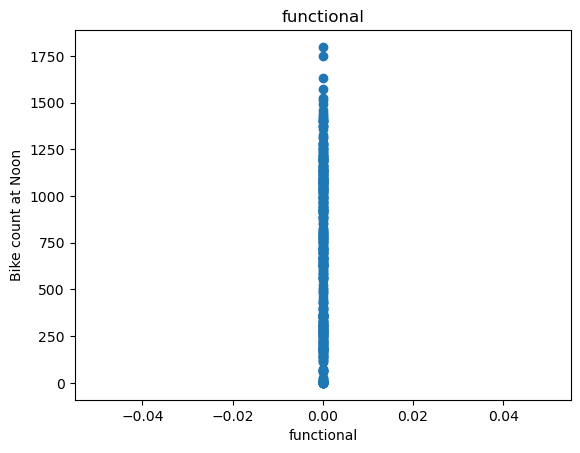

In [19]:
for label in df.columns[1:]:
    plt.scatter(df[label],df['bike_count'])
    plt.title(label)
    plt.ylabel('Bike count at Noon')
    plt.xlabel(label)
    plt.show()

In [ ]:
df = df.drop(['wind','visibility','functional'], axis = 1)

In [22]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


## Train/valid/test dataset

In [50]:
# Splitting datasets into 60% train, 20% validation and 20% test
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)),int(0.8*len(df))])

C:\Users\User\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [51]:
def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1,1)
        else:
            X = dataframe[x_labels].values
    
    y = dataframe[y_label].values.reshape(-1,1)
    data = np.hstack((X,y))
    
    return data, X, y

In [52]:
_, X_train_temp, y_train_temp = get_xy(train,'bike_count',x_labels=['temp',])
_, X_val_temp, y_val_temp = get_xy(val,'bike_count',x_labels=['temp',])
_, X_test_temp, y_test_temp = get_xy(test,'bike_count',x_labels=['temp',])

In [53]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [54]:
print(temp_reg.coef_, temp_reg.intercept_)

[[20.3170593]] [387.6976246]


In [55]:
temp_reg.score(X_test_temp, y_test_temp)   # Rsquared

0.3628532643562823

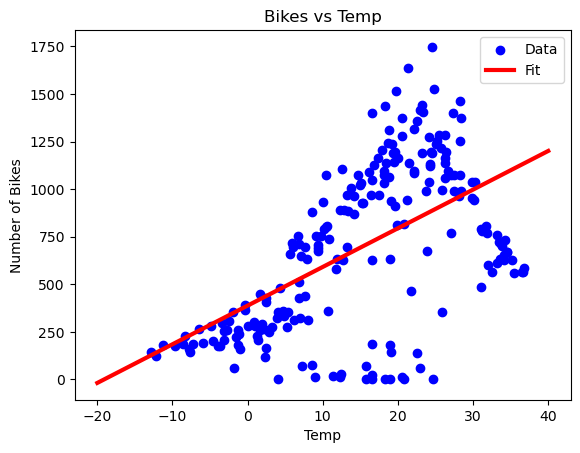

In [56]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of Bikes')
plt.xlabel('Temp')
plt.show()

## Multiple linear regression

In [62]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)),int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train,'bike_count',x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val,'bike_count',x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test,'bike_count',x_labels=df.columns[1:])

C:\Users\User\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [63]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [64]:
all_reg.score(X_test_all, y_test_all)

0.5232708176554597

## Regression with Neural Network

In [73]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')    # epoch is training cycles
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

In [65]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [67]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [68]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [69]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_temp,y_val_temp)
)

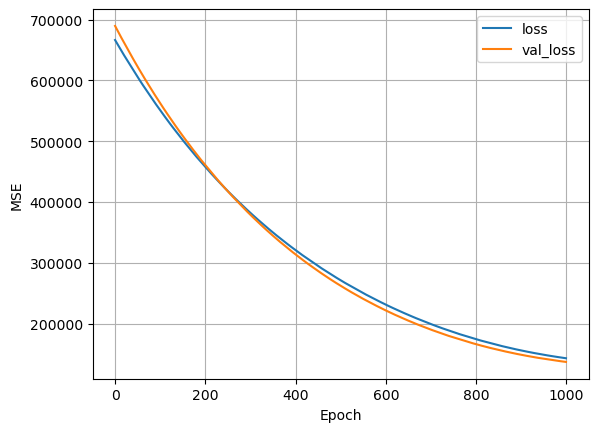

In [74]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


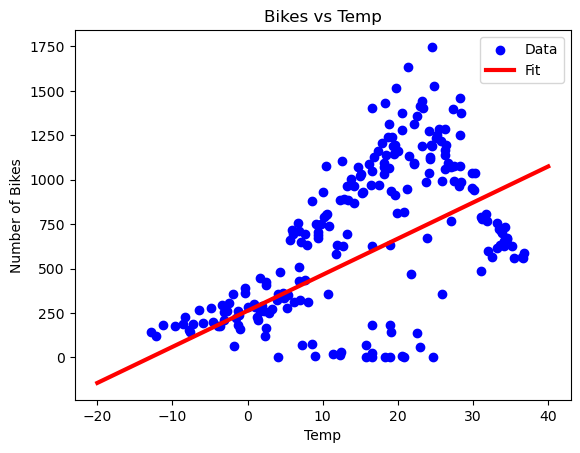

In [75]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of Bikes')
plt.xlabel('Temp')
plt.show()

The linear regression here is different from the one before, because this regression is using backpropagation to train the neural network and find the line of best fit

-------

### Repeat the same exercise using both method for all the other features

#### Humidity

In [78]:
# Getting x and y using LinearRegression() method
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)),int(0.8*len(df))])
_, X_train_humidity, y_train_humidity = get_xy(train,'bike_count',x_labels=['humidity',])
_, X_val_humidity, y_val_humidity = get_xy(val,'bike_count',x_labels=['humidity',])
_, X_test_humidity, y_test_humidity = get_xy(test,'bike_count',x_labels=['humidity',])

C:\Users\User\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [79]:
humidity_reg = LinearRegression()
humidity_reg.fit(X_train_humidity, y_train_humidity)

LinearRegression()

In [80]:
print(humidity_reg.coef_, humidity_reg.intercept_)

[[-3.04217468]] [841.07702616]


In [94]:
humidity_reg.score(X_test_humidity, y_test_humidity)

0.06353062307160984

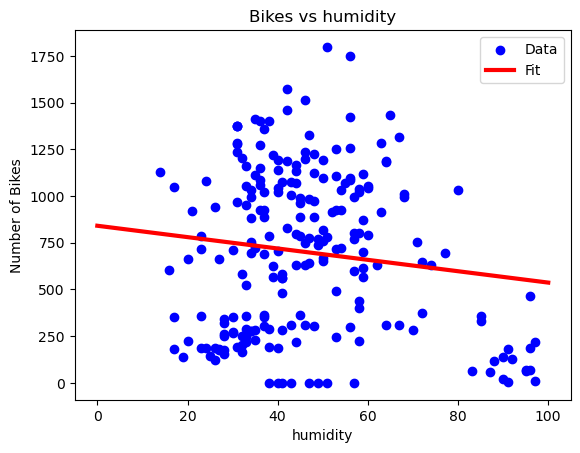

In [84]:
plt.scatter(X_train_humidity, y_train_humidity, label='Data', color='blue')
x = tf.linspace(0, 100, 100)
plt.plot(x, humidity_reg.predict(np.array(x).reshape(-1,1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs humidity')
plt.ylabel('Number of Bikes')
plt.xlabel('humidity')
plt.show()

In [85]:
humidity_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
humidity_normalizer.adapt(X_train_humidity.reshape(-1))

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [86]:
humidity_nn_model = tf.keras.Sequential([
    humidity_normalizer,
    tf.keras.layers.Dense(1)
])

In [87]:
humidity_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), 
                      loss='mean_squared_error')

In [88]:
history = humidity_nn_model.fit(
    X_train_humidity.reshape(-1), y_train_humidity,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_humidity,y_val_humidity)
)

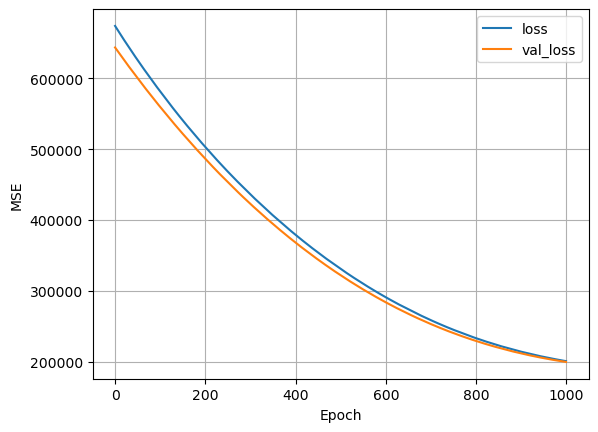

In [89]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


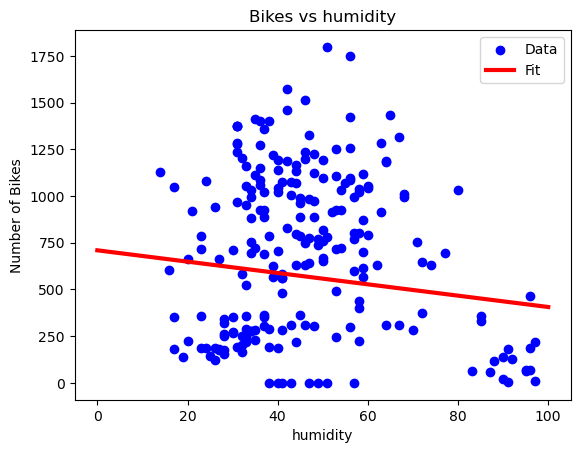

In [90]:
plt.scatter(X_train_humidity, y_train_humidity, label='Data', color='blue')
x = tf.linspace(0, 100, 100)
plt.plot(x, humidity_nn_model.predict(np.array(x).reshape(-1,1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs humidity')
plt.ylabel('Number of Bikes')
plt.xlabel('humidity')
plt.show()

#### Dew_pt_temp

#### Radiation

#### Rain

#### Snow

## Neural network model

In [104]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1),
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                      loss='mean_squared_error')

In [105]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data = (X_val_temp, y_val_temp),
    verbose=0, epochs = 100
)

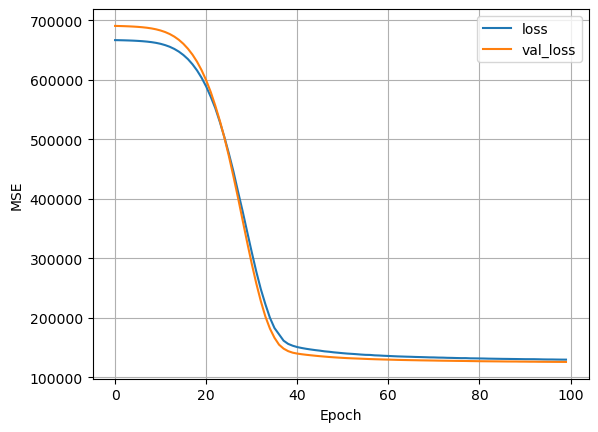

In [106]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


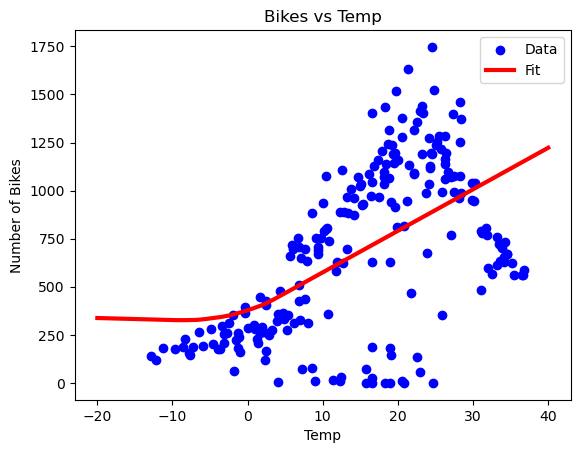

In [107]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1,1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of Bikes')
plt.xlabel('Temp')
plt.show()

In [111]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=None)
all_normalizer.adapt(X_train_all.reshape(-1))

In [115]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1),
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                      loss='mean_squared_error')

In [116]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data = (X_val_all, y_val_all),
    verbose=0, epochs = 100
)

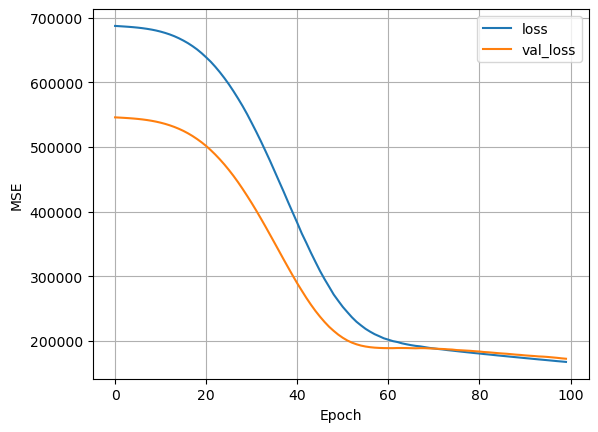

In [117]:
plot_loss(history)

## Calculate the MSE for both linear reg and nn

In [120]:
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [119]:
def MSE(y_pred,y_real):
    return (np.square(y_pred-y_real)).mean()

In [121]:
MSE(y_pred_lr,y_test_all)

98015.6352926731

In [122]:
MSE(y_pred_nn,y_test_all)

223514.49132465353

## Plotting actual y_pred vs y_actual

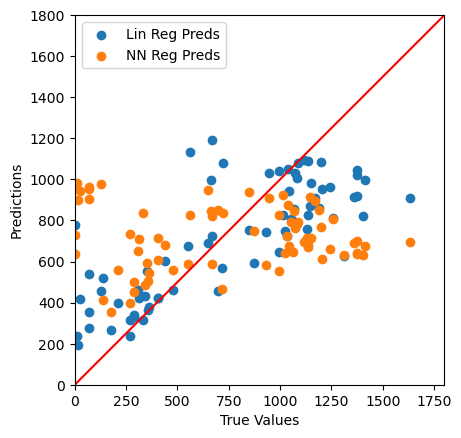

In [125]:
ax = plt.axes(aspect='equal')
plt.scatter(y_test_all, y_pred_lr, label ='Lin Reg Preds')
plt.scatter(y_test_all, y_pred_nn, label ='NN Reg Preds')
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims=[0,1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_=plt.plot(lims,lims,c='red')

Multiple linear regression work better than Neural Network for this case